# Prediction analisys

first of all we need to define the target variable. The simplest way is to

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('dataset/incident_profile_95.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            22516 non-null  int64  
 1   CRASH_MONTH                           22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    22516 non-null  float64
 3   avg_responsibility_score              22516 non-null  float64
 4   avg_weather_severity                  22516 non-null  float64
 5   avg_roadway_severity                  22516 non-null  float64
 6   avg_lighting_severity                 22516 non-null  float64
 7   total_crashes                         22516 non-null  int64  
 8   fatality_rate                         22516 non-null  float64
 9   severe_injury_rate                    22516 non-null  float64
 10  avg_crash_severity_score              22516 non-null  float64
 11  injury_severity

In [3]:
# create a towed_runit_rate column,num_towed_units_LB w.r.t. monthly_total_units
df['towed_runit_rate'] = df['num_towed_units_LB'] / df['monthly_total_units']

In [4]:
categorical_columns = [col for col in df.columns if col.startswith("sum_")]
non_categorical_columns = df.columns.difference(categorical_columns)

In [5]:
df[non_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BEAT_OF_OCCURRENCE              22516 non-null  float64
 1   CRASH_MONTH                     22516 non-null  int64  
 2   CRASH_YEAR                      22516 non-null  int64  
 3   adverse_weather_crash_rate      22516 non-null  float64
 4   avg_age                         22516 non-null  float64
 5   avg_crash_severity_score        22516 non-null  float64
 6   avg_lighting_severity           22516 non-null  float64
 7   avg_responsibility_score        22516 non-null  float64
 8   avg_roadway_severity            22516 non-null  float64
 9   avg_weather_severity            22516 non-null  float64
 10  combined_weather_road_severity  22516 non-null  float64
 11  damage_cost_LB                  22516 non-null  int64  
 12  damage_high                     

In [6]:
columns_to_drop = ['avg_weather_severity','avg_roadway_severity', 'damage_high', 'damage_low', 'damage_medium', 'total_drivers', 'total_units_department']
df = df.drop(columns=categorical_columns + columns_to_drop)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22516 entries, 0 to 22515
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CRASH_YEAR                      22516 non-null  int64  
 1   CRASH_MONTH                     22516 non-null  int64  
 2   BEAT_OF_OCCURRENCE              22516 non-null  float64
 3   avg_responsibility_score        22516 non-null  float64
 4   avg_lighting_severity           22516 non-null  float64
 5   total_crashes                   22516 non-null  int64  
 6   fatality_rate                   22516 non-null  float64
 7   severe_injury_rate              22516 non-null  float64
 8   avg_crash_severity_score        22516 non-null  float64
 9   injury_severity_score           22516 non-null  float64
 10  night_crash_rate                22516 non-null  float64
 11  adverse_weather_crash_rate      22516 non-null  float64
 12  road_defect_crash_rate          

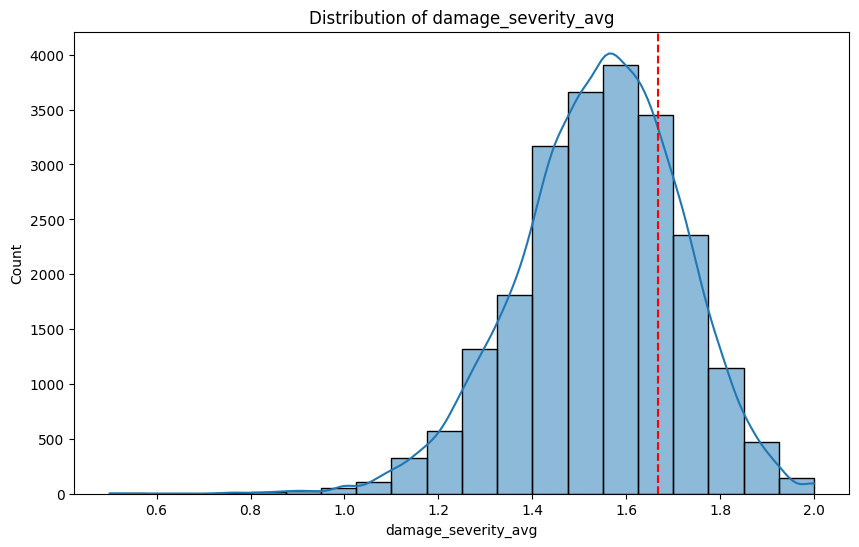

In [7]:
# distribution of damage_severity_avg
plt.figure(figsize=(10, 6))
sns.histplot(df['damage_severity_avg'], bins=20, kde=True)
plt.axvline(df['damage_severity_avg'].quantile(0.75), color='red', linestyle='--')
plt.title('Distribution of damage_severity_avg')
plt.show()


---

## Target variable definition
we will use the 75% quantile as the threshold for the damage_severity_avg, if the value is above this threshold we will consider it as a high damage and the Y value will be 1, otherwise 0


In [8]:
# first analisys using the damage_cost_LB column
df['DAMAGE_HIGH'] = df['damage_severity_avg'] > df['damage_severity_avg'].quantile(0.75)
df['DAMAGE_HIGH'] = df['DAMAGE_HIGH'].astype(int)


In [9]:
# DAMAGE columns
damage_columns = ['damage_cost_LB', 'damage_severity_avg']
df.drop(columns=damage_columns, inplace=True)
df.drop(columns=['BEAT_OF_OCCURRENCE'], inplace=True)

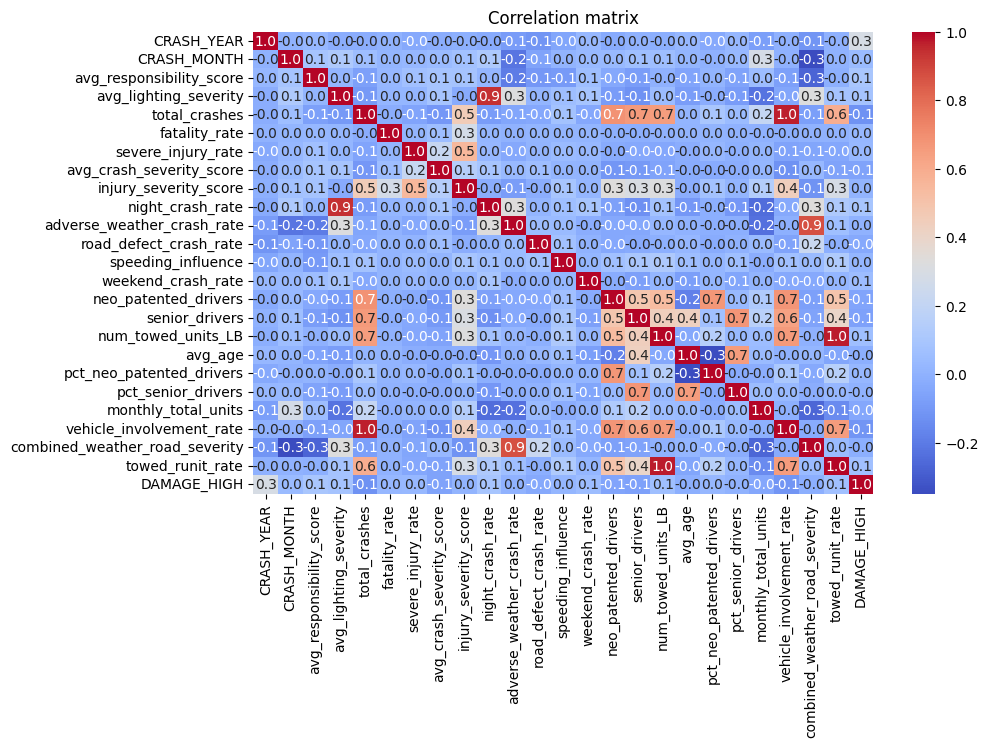

In [10]:
# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation matrix')
plt.show()


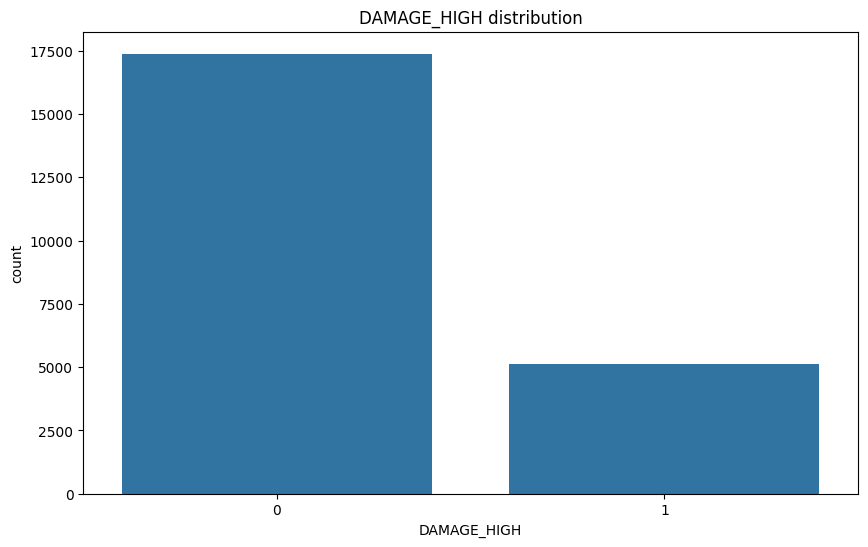

In [11]:
# plot DAMAGE_HIGH distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DAMAGE_HIGH')
plt.title('DAMAGE_HIGH distribution')
plt.show()


In [12]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

In [13]:
len(df_train), len(df_test)

(19289, 3227)

In [14]:
len(df_test) / len(df_train) * 100

16.729742340193894

## X and Y features

In [15]:
X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 24), (19289,), (3227, 24), (3227,))

---

# Models

The models that we will be using will be:
- Decision Trees
- Knn
- Naive Bayes
- Random Forests
- XGBoost
- Ada Boost
- Neural Network

## Random Forest

In [16]:
np.random.seed(42)
sklearn_random_seed = 42

In [17]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

hp_dt = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
}

from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))



Train accuracy: 0.55
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[1913,    0],
       [1314,    0]])

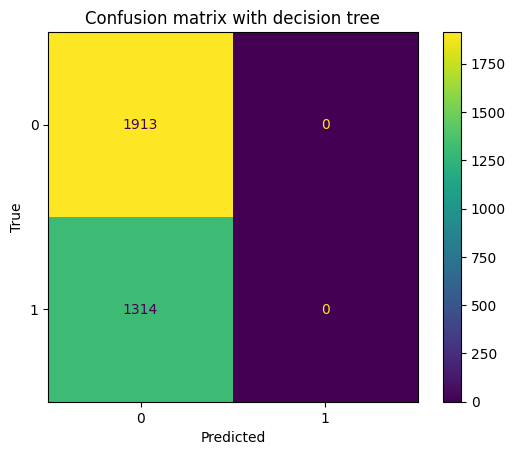

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns

cm = confusion_matrix(y_test, grid_dt.predict(X_test))
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')
plt.show()

---

## KNN

In [20]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

100%|██████████| 11/11 [00:05<00:00,  1.95it/s]


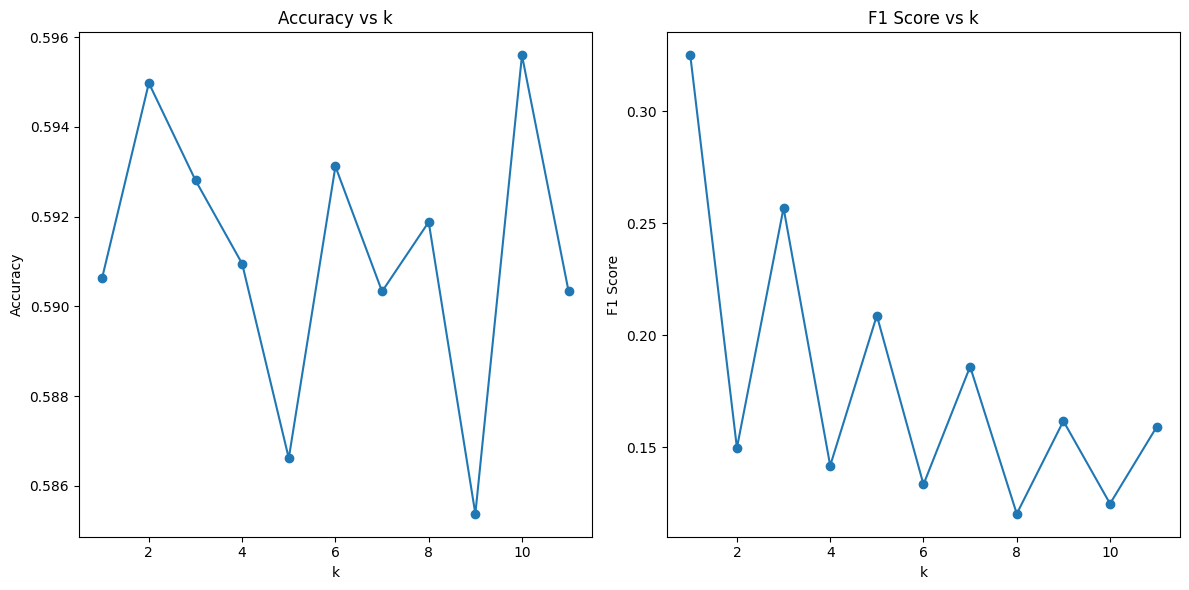

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.88      0.72      1913
           1       0.50      0.17      0.26      1314

    accuracy                           0.59      3227
   macro avg       0.55      0.53      0.49      3227
weighted avg       0.56      0.59      0.53      3227



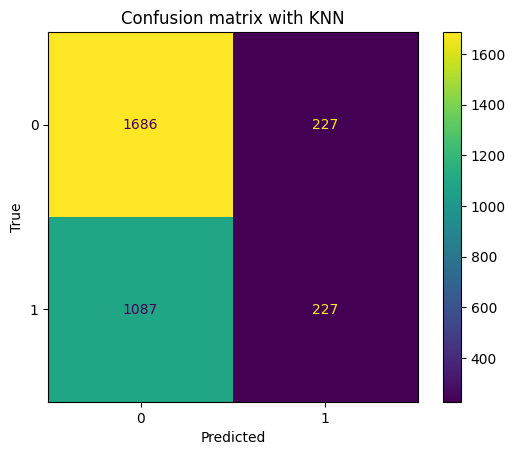

In [22]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

## Random Forest

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

hp_rf = {
    'n_estimators': [8, 16, 32, 64],
    'max_depth': [3, 7, 11],
    'min_samples_split': [4, 8, 16],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_




Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 8}

In [24]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))

Train accuracy: 0.74
Test accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1913
           1       0.00      0.00      0.00      1314

    accuracy                           0.59      3227
   macro avg       0.30      0.50      0.37      3227
weighted avg       0.35      0.59      0.44      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[1913,    0],
       [1314,    0]])

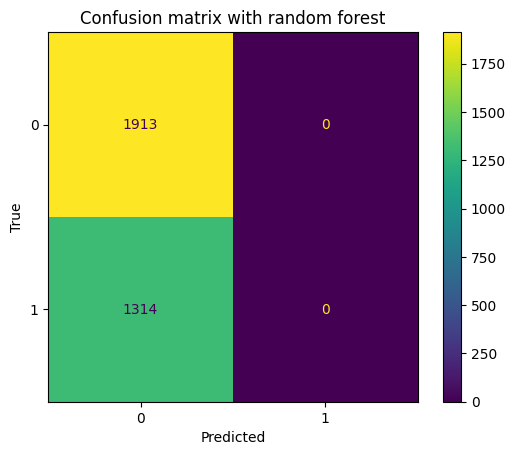

In [26]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion matrix with random forest')
plt.show()

---

## feature analisys with SHAP

In [27]:
import shap

explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)

In [28]:
shap_values = explainer.shap_values(X_test)

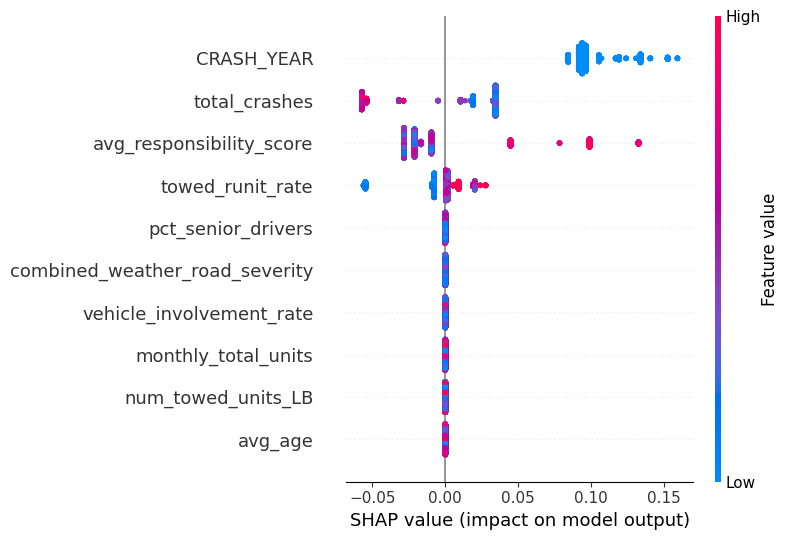

In [29]:
# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

In [30]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'total_crashes', 'fatality_rate',
       'severe_injury_rate', 'avg_crash_severity_score',
       'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'vehicle_involvement_rate', 'combined_weather_road_severity',
       'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

---

# Balancing the dataset

In [31]:
# balance the training set by under-sampling the majority class

df_under = pd.concat([df_train[df_train['DAMAGE_HIGH'] == 0].sample(n=df_train['DAMAGE_HIGH'].sum(), random_state=42), df_train[df_train['DAMAGE_HIGH'] == 1]])

df_under['DAMAGE_HIGH'].value_counts()

DAMAGE_HIGH
0    3817
1    3817
Name: count, dtype: int64

In [32]:
X_train_under = df_under.drop(columns=['DAMAGE_HIGH'])
y_train_under = df_under['DAMAGE_HIGH']


In [33]:
# Decision Tree with under-sampling
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt_under = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt_under.fit(X_train_under, y_train_under)

grid_dt_under.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [34]:
print(f"Train accuracy: {grid_dt_under.best_score_:.2f}")
print(f"Test accuracy: {grid_dt_under.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt_under.predict(X_test)))
confusion_matrix(y_test, grid_dt_under.predict(X_test))

Train accuracy: 0.54
Test accuracy: 0.41
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1913
           1       0.41      1.00      0.58      1314

    accuracy                           0.41      3227
   macro avg       0.20      0.50      0.29      3227
weighted avg       0.17      0.41      0.24      3227



c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

array([[   0, 1913],
       [   0, 1314]])

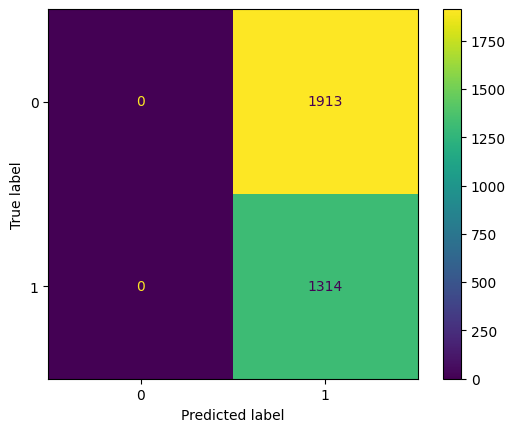

In [35]:
# confusion matrix
cm_under = confusion_matrix(y_test, grid_dt_under.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_under, display_labels=grid_dt_under.classes_)
disp.plot()

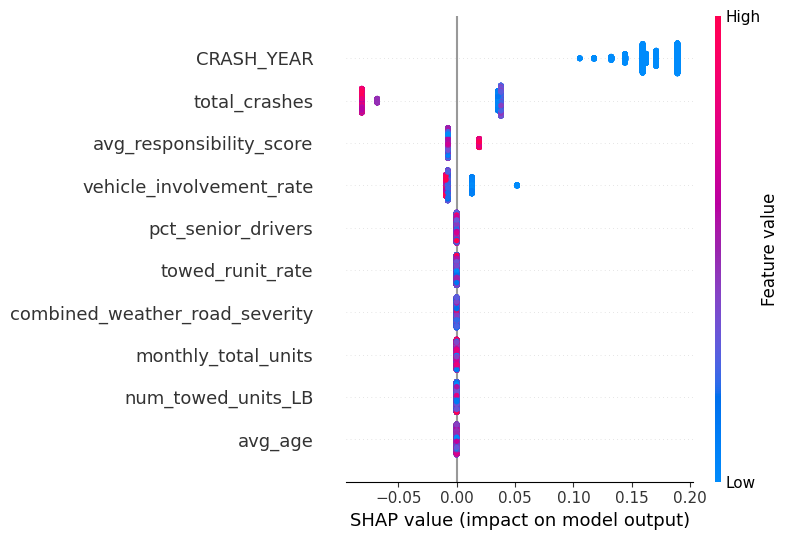

In [36]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt_under.best_estimator_)
shap_values = explainer.shap_values(X_test)


shap_values_class_1 = shap_values[:, :, 1]
shap_values_class_0 = shap_values[:, :, 0]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)

---

## Decision Tree without highly correlated features

In [35]:
# decision tree
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [36]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")

print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))


Train accuracy: 0.95
Test accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2316
           1       0.95      0.84      0.89       911

    accuracy                           0.94      3227
   macro avg       0.94      0.91      0.93      3227
weighted avg       0.94      0.94      0.94      3227



array([[2273,   43],
       [ 143,  768]])

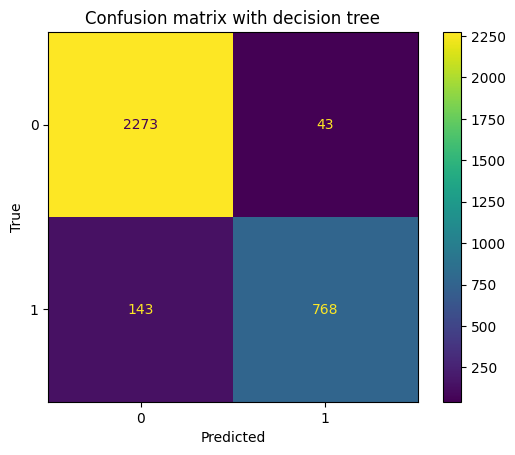

In [37]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')

plt.show()


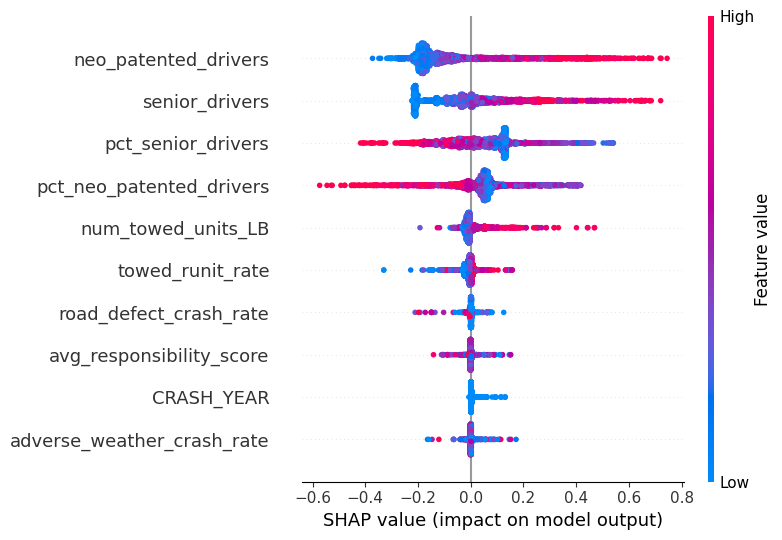

In [38]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


---

## More feature removal

Let's try to remove all the feature that capture the number of event, such as number of drivers of a specific age or number of towed vehicles, which could capture the magnitude of the number of crashes happened a given month for a department which, as we saw, is highly correlated to the total damage.

In [39]:
df.columns

Index(['CRASH_YEAR', 'CRASH_MONTH', 'avg_responsibility_score',
       'avg_lighting_severity', 'fatality_rate', 'severe_injury_rate',
       'avg_crash_severity_score', 'injury_severity_score', 'night_crash_rate',
       'adverse_weather_crash_rate', 'road_defect_crash_rate',
       'speeding_influence', 'weekend_crash_rate', 'neo_patented_drivers',
       'senior_drivers', 'num_towed_units_LB', 'avg_age',
       'pct_neo_patented_drivers', 'pct_senior_drivers', 'monthly_total_units',
       'combined_weather_road_severity', 'towed_runit_rate', 'DAMAGE_HIGH'],
      dtype='object')

In [40]:
columns_with_count = ['neo_patented_drivers', 'senior_drivers', 'num_towed_units_LB']

In [41]:
df = df.drop(columns=columns_with_count)

In [42]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 19), (19289,), (3227, 19), (3227,))

---

### Decision Tree without flat numbers

In [43]:
dt = DecisionTreeClassifier(random_state=sklearn_random_seed)

grid_dt = GridSearchCV(estimator=dt, param_grid=hp_dt, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

grid_dt.best_params_


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [44]:
print(f"Train accuracy: {grid_dt.best_score_:.2f}")
print(f"Test accuracy: {grid_dt.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_dt.predict(X_test)))
confusion_matrix(y_test, grid_dt.predict(X_test))

Train accuracy: 0.86
Test accuracy: 0.85
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2316
           1       0.80      0.62      0.70       911

    accuracy                           0.85      3227
   macro avg       0.83      0.78      0.80      3227
weighted avg       0.84      0.85      0.84      3227



array([[2174,  142],
       [ 349,  562]])

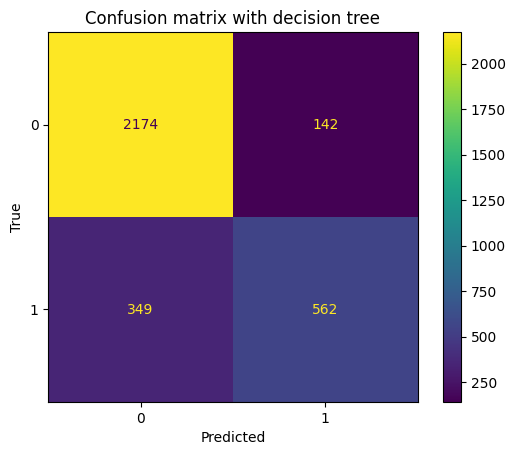

In [45]:
# confusion matrix
cm = confusion_matrix(y_test, grid_dt.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with decision tree')

plt.show()

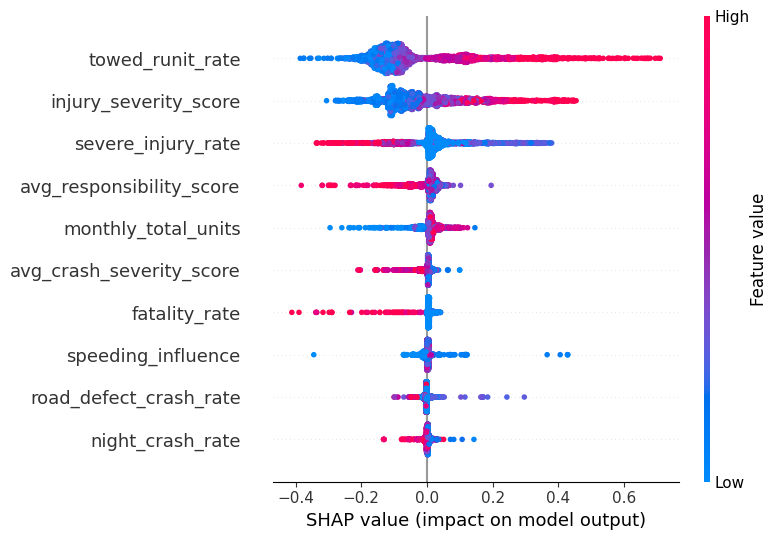

In [46]:
# shap values
explainer = shap.TreeExplainer(model=grid_dt.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


---

### Knn

100%|██████████| 11/11 [00:04<00:00,  2.28it/s]


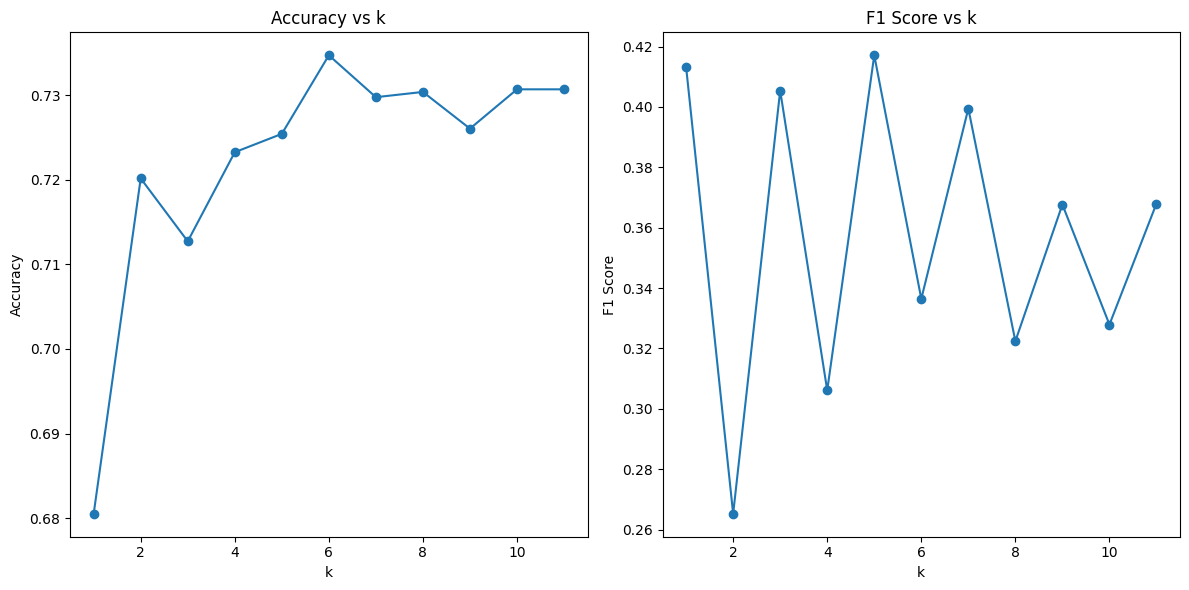

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# List of k values to try
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Lists to store the results
accuracies = []
f1_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Store the results
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')

plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='o')
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('F1 Score vs k')

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      2316
           1       0.52      0.35      0.42       911

    accuracy                           0.73      3227
   macro avg       0.65      0.61      0.62      3227
weighted avg       0.70      0.73      0.71      3227



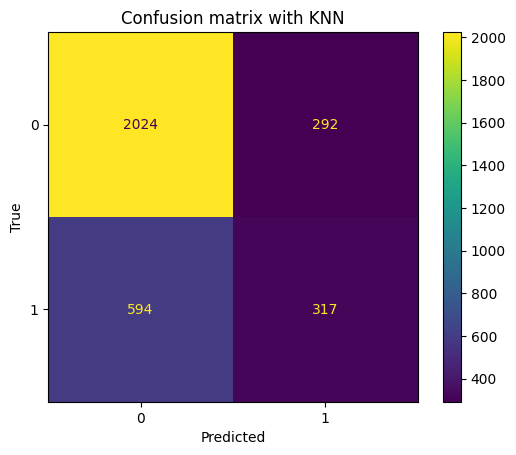

In [48]:
# confusion matrix with best k
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with KNN')
plt.show()

---

### Random Forest

In [49]:
# Random Forest

rf = RandomForestClassifier(random_state=sklearn_random_seed)

grid_rf = GridSearchCV(estimator=rf, param_grid=hp_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

grid_rf.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 64}

In [50]:
print(f"Train accuracy: {grid_rf.best_score_:.2f}")
print(f"Test accuracy: {grid_rf.score(X_test, y_test):.2f}")
print(classification_report(y_test, grid_rf.predict(X_test)))
confusion_matrix(y_test, grid_rf.predict(X_test))


Train accuracy: 0.89
Test accuracy: 0.87
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2316
           1       0.91      0.60      0.73       911

    accuracy                           0.87      3227
   macro avg       0.89      0.79      0.82      3227
weighted avg       0.88      0.87      0.86      3227



array([[2263,   53],
       [ 360,  551]])

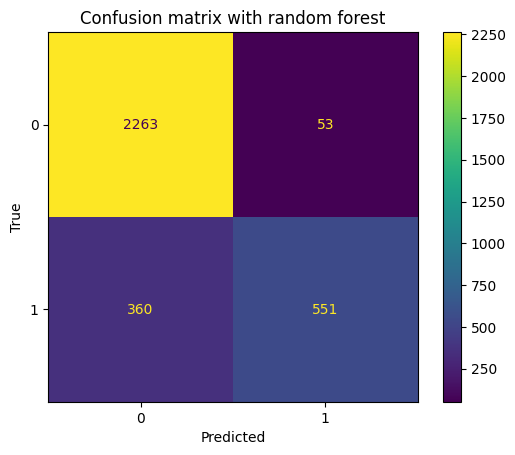

In [51]:
# confusion matrix
cm_rf = confusion_matrix(y_test, grid_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=grid_rf.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with random forest')

plt.show()


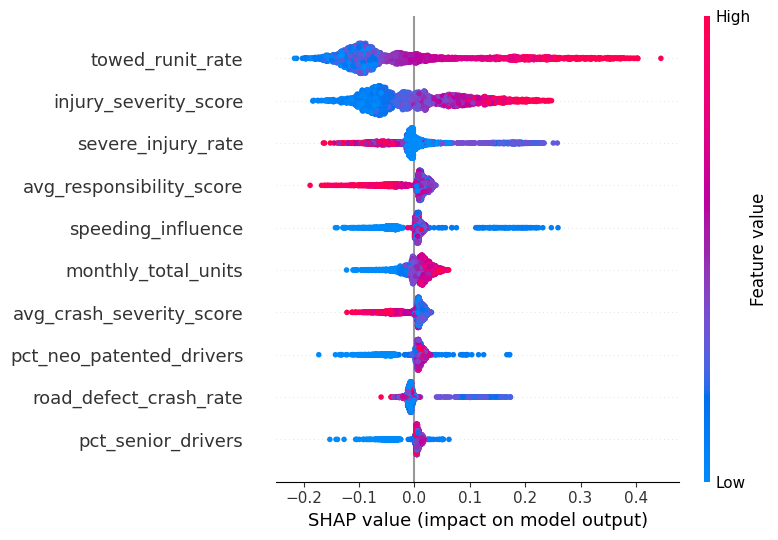

In [52]:
# shape values for random forest
explainer = shap.TreeExplainer(model=grid_rf.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, X_test, max_display=10)


---

### Naive Bayes


Train accuracy: 0.77
Test accuracy: 0.73
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      2316
           1       0.52      0.63      0.57       911

    accuracy                           0.73      3227
   macro avg       0.68      0.70      0.69      3227
weighted avg       0.75      0.73      0.74      3227



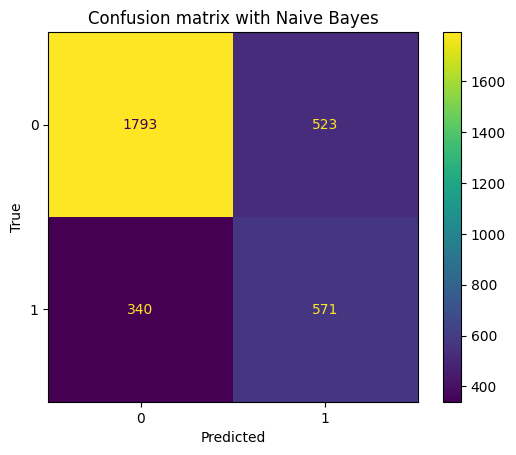

In [53]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

print(f"Train accuracy: {nb.score(X_train, y_train):.2f}")
print(f"Test accuracy: {nb.score(X_test, y_test):.2f}")
print(classification_report(y_test, nb.predict(X_test)))

# confusion matrix
cm_nb = confusion_matrix(y_test, nb.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Naive Bayes')

plt.show()

---

### XGBoost

In [54]:
from xgboost import XGBClassifier


base_model = XGBClassifier()
hyperparameters_xg = {
    "n_estimators": [25, 100, 250],
    "max_depth": [2, 4, 8],
    "learning_rate": [0.1, 0.001, 0.0001]
}
search = GridSearchCV(base_model, hyperparameters_xg, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
xg_boost = search.best_estimator_
xg_boost.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [55]:
print(f"Train accuracy: {xg_boost.score(X_train, y_train):.2f}")
print(f"Test accuracy: {xg_boost.score(X_test, y_test):.2f}")
print(classification_report(y_test, xg_boost.predict(X_test)))
confusion_matrix(y_test, xg_boost.predict(X_test))


Train accuracy: 0.92
Test accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2316
           1       0.93      0.71      0.81       911

    accuracy                           0.90      3227
   macro avg       0.91      0.84      0.87      3227
weighted avg       0.91      0.90      0.90      3227



array([[2268,   48],
       [ 264,  647]])

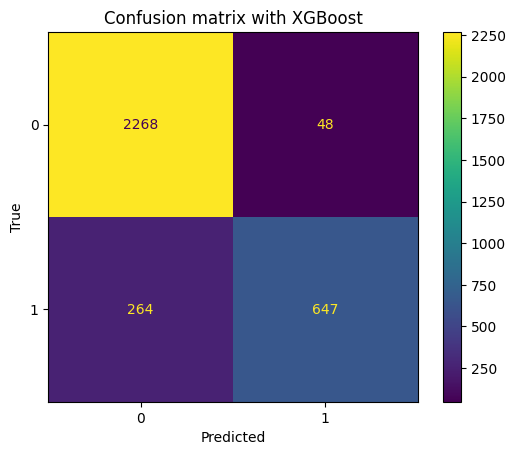

In [56]:
# confusion matrix
cm_xg = confusion_matrix(y_test, xg_boost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xg, display_labels=xg_boost.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with XGBoost')

plt.show()

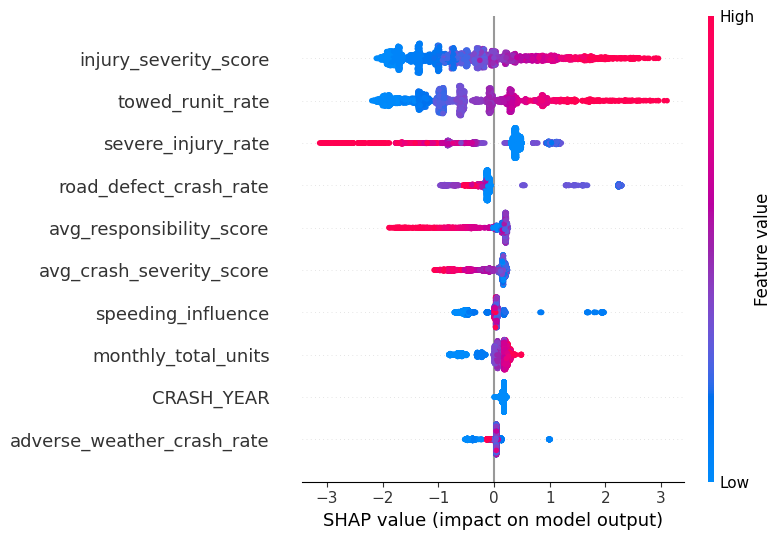

In [57]:
# shap values
explainer = shap.TreeExplainer(model=xg_boost)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for all classes
shap_values_all_classes = shap_values

shap.summary_plot(shap_values_all_classes, X_test, max_display=10)



---

### ADA Boost

In [58]:
# ADA Boost
from sklearn.ensemble import AdaBoostClassifier

base_model = AdaBoostClassifier()
hyperparameters_ada = {
    "n_estimators": [25, 100, 250],
    "learning_rate": [0.1, 0.001, 0.0001]
}
search = GridSearchCV(base_model, hyperparameters_ada, cv=5, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
ada_boost = search.best_estimator_
ada_boost.fit(X_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\chucki\Desktop\projects\DM-Project2\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.1, n_estimators=250)

In [59]:
print(f"Train accuracy: {ada_boost.score(X_train, y_train):.2f}")
print(f"Test accuracy: {ada_boost.score(X_test, y_test):.2f}")
print(classification_report(y_test, ada_boost.predict(X_test)))
confusion_matrix(y_test, ada_boost.predict(X_test))

Train accuracy: 0.90
Test accuracy: 0.86
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2316
           1       0.92      0.57      0.70       911

    accuracy                           0.86      3227
   macro avg       0.89      0.78      0.81      3227
weighted avg       0.87      0.86      0.85      3227



array([[2272,   44],
       [ 392,  519]])

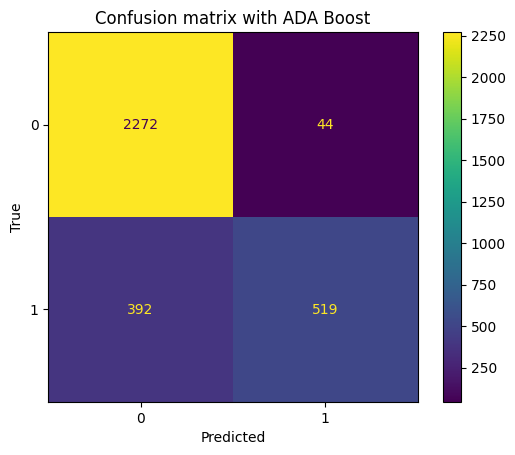

In [60]:
# confusion matrix
cm_ada = confusion_matrix(y_test, ada_boost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=ada_boost.classes_)
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with ADA Boost')

plt.show()

---

### Neural Network

In [61]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19289, 19), (19289,), (3227, 19), (3227,))

In [62]:
X_test.shape

(3227, 19)

Hyperparameter search:   0%|          | 0/24 [00:00<?, ?combination/s]

Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


Hyperparameter search:   4%|▍         | 1/24 [00:31<11:54, 31.07s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:   8%|▊         | 2/24 [00:44<07:38, 20.84s/combination]

Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


Hyperparameter search:  12%|█▎        | 3/24 [01:03<07:01, 20.09s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  17%|█▋        | 4/24 [01:18<05:56, 17.80s/combination]

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


Hyperparameter search:  21%|██        | 5/24 [01:28<04:43, 14.91s/combination]

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


Hyperparameter search:  25%|██▌       | 6/24 [01:37<03:54, 13.05s/combination]

Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


Hyperparameter search:  29%|██▉       | 7/24 [01:57<04:23, 15.48s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  33%|███▎      | 8/24 [02:06<03:30, 13.15s/combination]

Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


Hyperparameter search:  38%|███▊      | 9/24 [02:32<04:21, 17.40s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  42%|████▏     | 10/24 [02:50<04:04, 17.43s/combination]

Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


Hyperparameter search:  46%|████▌     | 11/24 [03:13<04:08, 19.08s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  50%|█████     | 12/24 [03:28<03:36, 18.00s/combination]

Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


Hyperparameter search:  54%|█████▍    | 13/24 [03:39<02:53, 15.77s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  58%|█████▊    | 14/24 [03:48<02:18, 13.84s/combination]

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


Hyperparameter search:  62%|██████▎   | 15/24 [04:02<02:04, 13.80s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  67%|██████▋   | 16/24 [04:12<01:42, 12.80s/combination]

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


Hyperparameter search:  71%|███████   | 17/24 [04:39<01:58, 16.91s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  75%|███████▌  | 18/24 [04:56<01:41, 16.91s/combination]

Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.


Hyperparameter search:  79%|███████▉  | 19/24 [05:29<01:49, 21.81s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  83%|████████▎ | 20/24 [05:46<01:21, 20.28s/combination]

Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.


Hyperparameter search:  88%|████████▊ | 21/24 [06:03<00:58, 19.49s/combination]

Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


Hyperparameter search:  92%|█████████▏| 22/24 [06:13<00:33, 16.58s/combination]

Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


Hyperparameter search:  96%|█████████▌| 23/24 [06:26<00:15, 15.54s/combination]

Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


Hyperparameter search: 100%|██████████| 24/24 [06:39<00:00, 16.64s/combination]

Best Hyperparameters: {'architecture': [64, 32], 'batch_size': 16, 'learning_rate': 0.0001, 'dropout': 0.0}


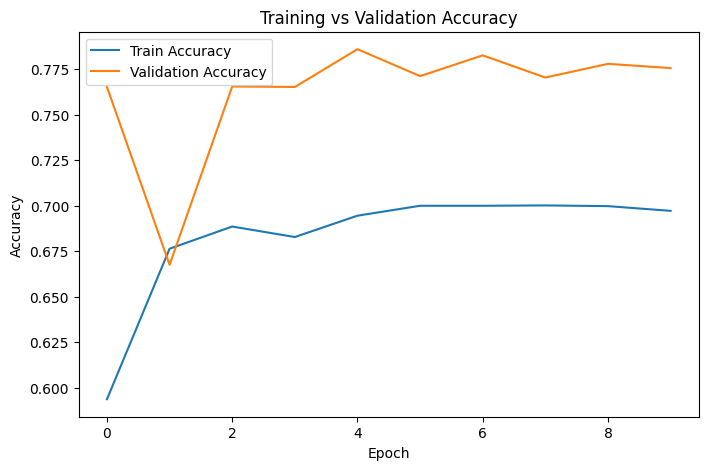

Test accuracy: 0.7341184020042419


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from itertools import product
from tqdm import tqdm

# Assume X, y is your full dataset.
X_train_full = X_train.copy()
y_train_full = y_train.copy()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Hyperparameter grid.
architectures = [
    [32],
    [64, 32],
    [128, 64, 32]
]
batch_sizes = [16, 32]
learning_rates = [1e-3, 1e-4]
dropout_rates = [0.0, 0.2]

# Total number of combinations.
param_combinations = list(product(architectures, batch_sizes, learning_rates, dropout_rates))

best_val_acc = -np.inf
best_model = None
best_history = None
best_params = {}

# Early stopping.
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Grid search with tqdm progress bar.
for arch, bs, lr, dr in tqdm(param_combinations, desc="Hyperparameter search", unit="combination"):
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1],)))
    for units in arch:
        model.add(Dense(units, activation='relu'))
        if dr > 0.0:
            model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=bs, 
                        validation_data=(X_val, y_val), callbacks=[es], verbose=0)
    
    current_val_acc = max(history.history['val_accuracy'])
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_model = model
        best_history = history
        best_params = {"architecture": arch, "batch_size": bs, "learning_rate": lr, "dropout": dr}

print("Best Hyperparameters:", best_params)

# Plot training vs validation accuracy.
plt.figure(figsize=(8, 5))
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set.
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", test_acc)

In [64]:
df_train = df[df['CRASH_YEAR'] != 2024]
df_test = df[df['CRASH_YEAR'] == 2024]

X_train = df_train.drop(columns=['DAMAGE_HIGH'])
y_train = df_train['DAMAGE_HIGH']

X_test = df_test.drop(columns=['DAMAGE_HIGH'])
y_test = df_test['DAMAGE_HIGH']

X_train.shape, y_train.shape, X_test.shape, y_test.shape



((19289, 19), (19289,), (3227, 19), (3227,))

In [65]:
from sklearn.model_selection import train_test_split

X_train_full = X_train.copy()
y_train_full = y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [66]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
import tensorflow as tf

def create_model(optimizer='adam', neurons1=128, neurons2=32):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(19,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(neurons1, activation='relu'),
    tf.keras.layers.Dense(neurons2, activation='relu'),  # Second layer
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['accuracy'])
  return model


In [67]:
# Wrap the model
model = KerasClassifier(build_fn=create_model, verbose=0, neurons1=128, neurons2=32)


In [74]:
# k-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

hyperparameters_nn = {
  'optimizer': ['adam'],
  'neurons1' : [64, 128, 256],
  'neurons2' : [32, 64],
  'batch_size': [32],
  'epochs': [7]
}

# grid search
grid_search_nn = GridSearchCV(estimator=model, param_grid=hyperparameters_nn, cv=kf, scoring='f1', n_jobs=-1, verbose=3)


In [ ]:
grid_search_nn.fit(X_train, y_train, validation_data=(X_val, y_val))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
# Print the best parameters and the best score
print(f"Best parameters: {grid_search_nn.best_params_}")
print(f"Best score: {grid_search_nn.best_score_}")

# Save the training and validation accuracy for the best model
history = grid_search_nn.best_estimator_.model_.history
training_acc = history.history.get('accuracy', [])
validation_acc = history.history.get('val_accuracy', [])

Best parameters: {'batch_size': 32, 'epochs': 7, 'neurons1': 256, 'neurons2': 64, 'optimizer': 'adam'}
Best score: 0.3136874128209995


              precision    recall  f1-score   support

           0       0.76      0.92      0.84      2316
           1       0.58      0.28      0.37       911

    accuracy                           0.74      3227
   macro avg       0.67      0.60      0.60      3227
weighted avg       0.71      0.74      0.70      3227



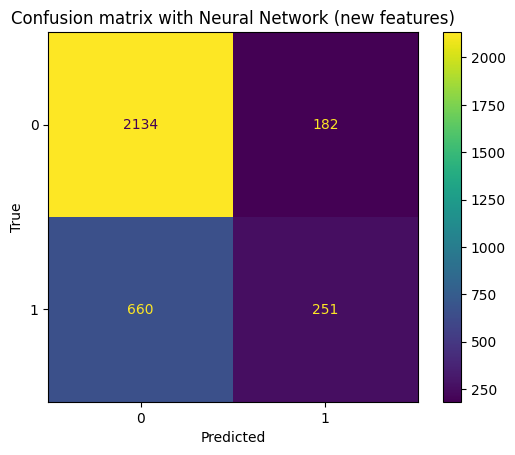

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# evaluation of the best model
best_model = grid_search_nn.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp.plot()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix with Neural Network (new features)')
plt.show()

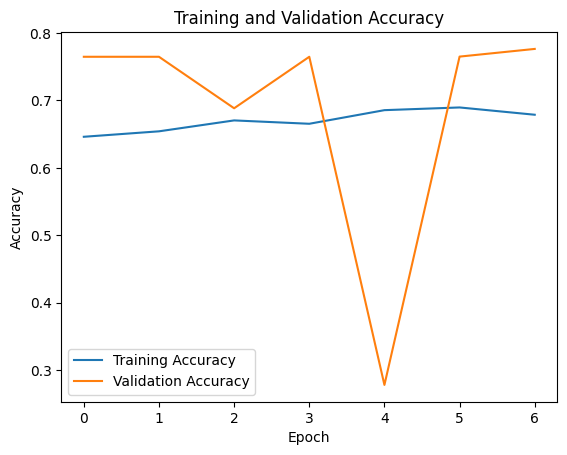

In [ ]:
#plot
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

---

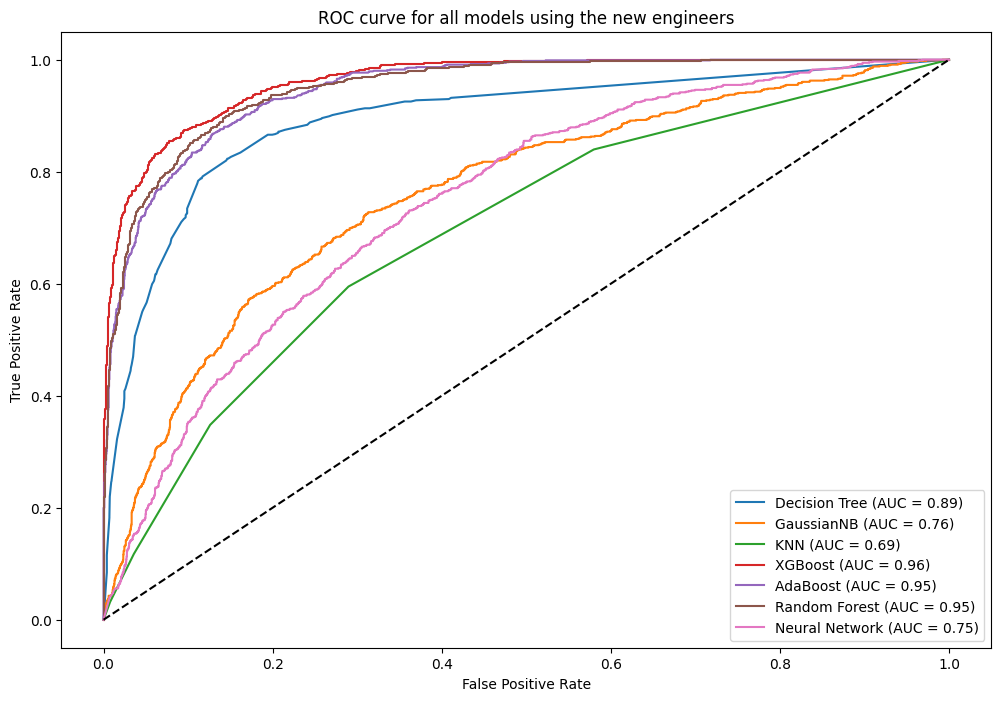

In [ ]:
# ROC curve for all the models

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
plt.figure(figsize=(12, 8))

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, grid_dt.predict_proba(X_test)[:, 1])
roc_auc_dt = roc_auc_score(y_test, grid_dt.predict_proba(X_test)[:, 1])
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)

# GaussianNB
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, nb.predict_proba(X_test)[:, 1])
roc_auc_gnb = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])
plt.plot(fpr_gnb, tpr_gnb, label='GaussianNB (AUC = %0.2f)' % roc_auc_gnb)

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % roc_auc_knn)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xg_boost.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xg_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

# AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_boost.predict_proba(X_test)[:, 1])
roc_auc_ada = roc_auc_score(y_test, ada_boost.predict_proba(X_test)[:, 1])
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = %0.2f)' % roc_auc_ada)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, grid_rf.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc_nn = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_nn, tpr_nn, label='Neural Network (AUC = %0.2f)' % roc_auc_nn)

plt.plot([0, 1], [0, 1], 'k--')  # middle line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all models using the new engineers')
plt.legend()

plt.show()